## 通过影评，对100部影片进行分类

In [1]:
# %load week08-1.py
"""
Created on Fri Sep 09 16:46:53 2016

@author: Administrator
"""

import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
#加载影片数据
titles = open('电影简介聚类数据/title_list.txt').read().split('\n')
titles = titles[:100]
titles[:10] #前 10 个片名

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic']

In [3]:
links = open('电影简介聚类数据/link_list_imdb.txt').read().split('\n')
links = links[:100]
links[:5]

['http://www.imdb.com/title/tt0068646/',
 'http://www.imdb.com/title/tt0111161/',
 'http://www.imdb.com/title/tt0108052/',
 'http://www.imdb.com/title/tt0081398/',
 'http://www.imdb.com/title/tt0034583/']

In [4]:
#wiki上的电影简介
synopses_wiki = open('电影简介聚类数据/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

#数据清洗，获取html代码中的文本内容
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'lxml').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
    
synopses_wiki = synopses_clean_wiki
synopses_wiki[:2]

['Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson 

In [5]:
genres = open('电影简介聚类数据/genres_list.txt').read().split('\n')
genres = genres[:100]
genres[:5]

["[u' Crime', u' Drama']",
 "[u' Crime', u' Drama']",
 "[u' Biography', u' Drama', u' History']",
 "[u' Biography', u' Drama', u' Sport']",
 "[u' Drama', u' Romance', u' War']"]

In [6]:
print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [7]:
#imdb网站上的电影简介
synopses_imdb = open('电影简介聚类数据/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb
synopses_imdb[:2]

['\n\nIn late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone\'s daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter\'s wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who\'d avoided most contact with the Don due to Corleone\'s nefarious business dealings. The Don\'s wife is godmother to Bonasera\'s shamed daughter, a relationship the Don uses to extract new loyalty from the undertaker. The Don agrees to have his

In [8]:
#把wiki和imdb网站上的简介合在一起
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [9]:
#为每个项目生成索引的全集(在本例中它只是排名),以后我将使用这个得分
ranks = []

for i in range(0,len(titles)):
    ranks.append(i) 

In [10]:
# 载入 nltk 的英文停用词作为“stopwords”变量
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
# 载入 nltk 的 SnowballStemmer 作为“stemmer”变量
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# 这里定义了一个分词器（tokenizer）和词干分析器（stemmer），它们会输出给定文本词干化后的词集合

def tokenize_and_stem(text):
    # 首先分句，接着分词，而标点也会作为词例存在
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    filtered_tokens = []
    # 过滤所有不含字母的词例（例如：数字、纯标点）
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [12]:
def tokenize_only(text):
    # 首先分句，接着分词，而标点也会作为词例存在
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # 过滤所有不含字母的词例（例如：数字、纯标点）
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [13]:
# 扩充列表后变成了非常庞大的二维（flat）词汇表
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #对每个电影的剧情简介进行分词和词干化
    totalvocab_stemmed.extend(allwords_stemmed) # 扩充“totalvocab_stemmed”列表

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 312302 items in vocab_frame


In [14]:
vocab_frame.head()#index是词干化后的词，value是词干化前的词

,words
plot,plot
edit,edit
edit,edit
edit,edit
on,on


In [15]:
# 定义向量化参数
from sklearn.feature_extraction.text import TfidfVectorizer
#
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [16]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) # 向量化剧情简介文本

CPU times: user 5.7 s, sys: 56.8 ms, total: 5.76 s
Wall time: 5.77 s


In [17]:
tfidf_matrix

<100x563 sparse matrix of type '<class 'numpy.float64'>'
	with 19907 stored elements in Compressed Sparse Row format>

In [18]:
print(tfidf_matrix.shape)#(100, 563) 100部影评，563个terms

(100, 563)


In [19]:
terms = tfidf_vectorizer.get_feature_names()
terms

["'d",
 "'s death",
 "'s father",
 "'s friend",
 "'s hous",
 "'s mother",
 'abandon',
 'abl',
 'accept',
 'accid',
 'accompani',
 'accus',
 'act',
 'action',
 'actual',
 'admit',
 'afterward',
 'ago',
 'agre',
 'air',
 'aliv',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'american',
 'angri',
 'angrili',
 'ani',
 'announc',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appear',
 'approach',
 'area',
 'argu',
 'arm',
 'armi',
 'arrang',
 'arrest',
 'arriv',
 'ask',
 'assign',
 'assist',
 'assum',
 'attack',
 'attempt',
 'attend',
 'attent',
 'attract',
 'audienc',
 'avoid',
 'away',
 'bad',
 'bar',
 'bare',
 'battl',
 'beat',
 'becaus',
 'becom',
 'bed',
 'beg',
 'believ',
 'best',
 'better',
 'big',
 'black',
 'blow',
 'board',
 'bodi',
 'book',
 'boss',
 'boy',
 'break',
 'brief',
 'bring',
 'broken',
 'brother',
 'build',
 'burn',
 'busi',
 'buy',
 'ca',
 "ca n't",
 'camp',
 'captain',
 'captur',
 'car',
 'care',
 'career',
 'carri',
 'case',
 'catch',
 'caus',
 'chanc'

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [21]:
##k-means聚类
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)

CPU times: user 325 ms, sys: 0 ns, total: 325 ms
Wall time: 326 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
clusters = km.labels_.tolist()
clusters

[4,
 3,
 2,
 1,
 1,
 3,
 4,
 4,
 4,
 3,
 2,
 4,
 3,
 3,
 3,
 3,
 4,
 4,
 1,
 3,
 4,
 3,
 4,
 4,
 2,
 1,
 0,
 3,
 3,
 2,
 4,
 2,
 1,
 2,
 4,
 1,
 2,
 3,
 3,
 1,
 4,
 0,
 4,
 3,
 4,
 3,
 4,
 4,
 2,
 3,
 4,
 3,
 3,
 4,
 1,
 2,
 3,
 2,
 4,
 4,
 4,
 3,
 2,
 3,
 4,
 0,
 4,
 0,
 3,
 4,
 4,
 3,
 3,
 3,
 4,
 0,
 3,
 4,
 4,
 1,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 2,
 4,
 1,
 3,
 3,
 3,
 3,
 4,
 1,
 1,
 3,
 3]

In [23]:
from sklearn.externals import joblib

# 注释语句用来存储你的模型
# 因为我已经从 pickle 载入过模型了
#joblib.dump(km,  'doc_cluster.pkl')

['doc_cluster.pkl']

In [24]:
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [25]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
frame['cluster'].value_counts()

3    38
4    33
2    12
1    12
0     5
Name: cluster, dtype: int64

In [26]:
grouped = frame['rank'].groupby(frame['cluster']) # 为了凝聚（aggregation），由聚类分类。

grouped.mean() # 每个聚类的平均排名（1 到 100）

cluster
0    54.800000
1    47.666667
2    39.583333
3    55.052632
4    46.575758
Name: rank, dtype: float64

In [27]:
print("Top terms per cluster:")
print()
# 按离质心的距离排列聚类中心，由近到远
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
order_centroids

Top terms per cluster:



array([[227, 317, 205, ..., 123, 413, 118],
       [213,  34, 376, ..., 112, 115, 350],
       [470,  41, 114, ..., 464,  27, 126],
       [ 91, 286, 224, ...,  24, 492, 280],
       [205, 207, 255, ..., 406, 314, 263]])

In [28]:
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :6]: # 每个聚类选 6 个词
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() # 空行
    print() # 空行

    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() # 空行
    print() # 空行

Cluster 0 words: b'george', b'marries', b'family', b'john', b'james', b'playing',

Cluster 0 titles: It's a Wonderful Life, The Philadelphia Story, The King's Speech, A Place in the Sun, Tootsie,

Cluster 1 words: b'fights', b'apartments', b'police', b'says', b'love', b'film',

Cluster 1 titles: Raging Bull, Casablanca, West Side Story, Singin' in the Rain, Gandhi, From Here to Eternity, Rocky, The Apartment, Shane, The Maltese Falcon, Rear Window, The Third Man,

Cluster 2 words: b'soldiers', b'army', b'command', b'war', b'killed', b'general',

Cluster 2 titles: Schindler's List, Lawrence of Arabia, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Saving Private Ryan, Patton, Platoon, Dances with Wolves, All Quiet on the Western Front, Stagecoach,

Cluster 3 words: b'car', b'killed', b'friends', b"n't", b'house', b'mr.',

Cluster 3 titles: The Shawshank Redemption, One Fle

/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


/home/ian/installed/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


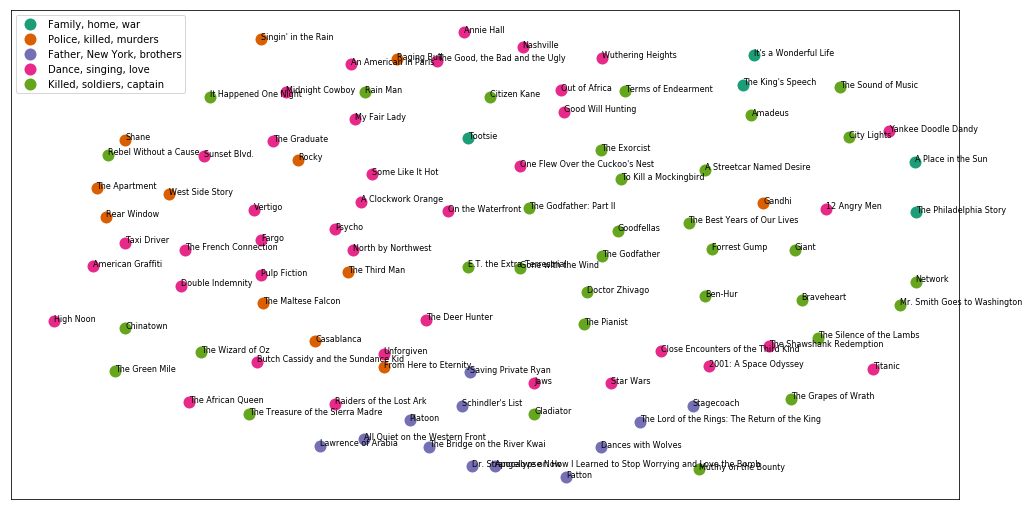

In [29]:
##多维尺度分析MDS    
import os  # 为了使用 os.path.basename 函数
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
MDS()
# 将二位平面中绘制的点转化成两个元素（components）
# 设置为“precomputed”是因为我们提供的是距离矩阵
# 我们可以将“random_state”具体化来达到重复绘图的目的
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # 形如 (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]


##可视化聚类
# 用字典设置每个聚类的颜色
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
# 用字典设置每个聚类名称
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}
                 
# 在 ipython 中内联（inline）演示 matplotlib 绘图
%matplotlib inline 

# 用 MDS 后的结果加上聚类编号和绘色创建 DataFrame
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# 聚类归类
groups = df.groupby('label')


# 设置绘图
fig, ax = plt.subplots(figsize=(17, 9)) # 设置大小
ax.margins(0.05) # 可选项，只添加 5% 的填充（padding）来自动缩放（auto scaling）。

# 对聚类进行迭代并分布在绘图上
# 我用到了 cluster_name 和 cluster_color 字典的“name”项，这样会返回相应的 color 和 label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',          # 使用 x 坐标轴
        which='both',      # 同时使用主刻度标签（major ticks）和次刻度标签（minor ticks）
        bottom='off',      # 取消底部边缘（bottom edge）标签
        top='off',         # 取消顶部边缘（top edge）标签
        labelbottom='off')
    ax.tick_params(
        axis= 'y',         # 使用 y 坐标轴
        which='both',      # 同时使用主刻度标签（major ticks）和次刻度标签（minor ticks）
        left='off',      # 取消底部边缘（bottom edge）标签
        top='off',         # 取消顶部边缘（top edge）标签
        labelleft='off')

ax.legend(numpoints=1)  # 图例（legend）中每项只显示一个点

# 在坐标点为 x,y 处添加影片名作为标签（label）
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show() # 展示绘图

# 以下注释语句可以保存需要的绘图
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [30]:
plt.close()

/home/ian/installed/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


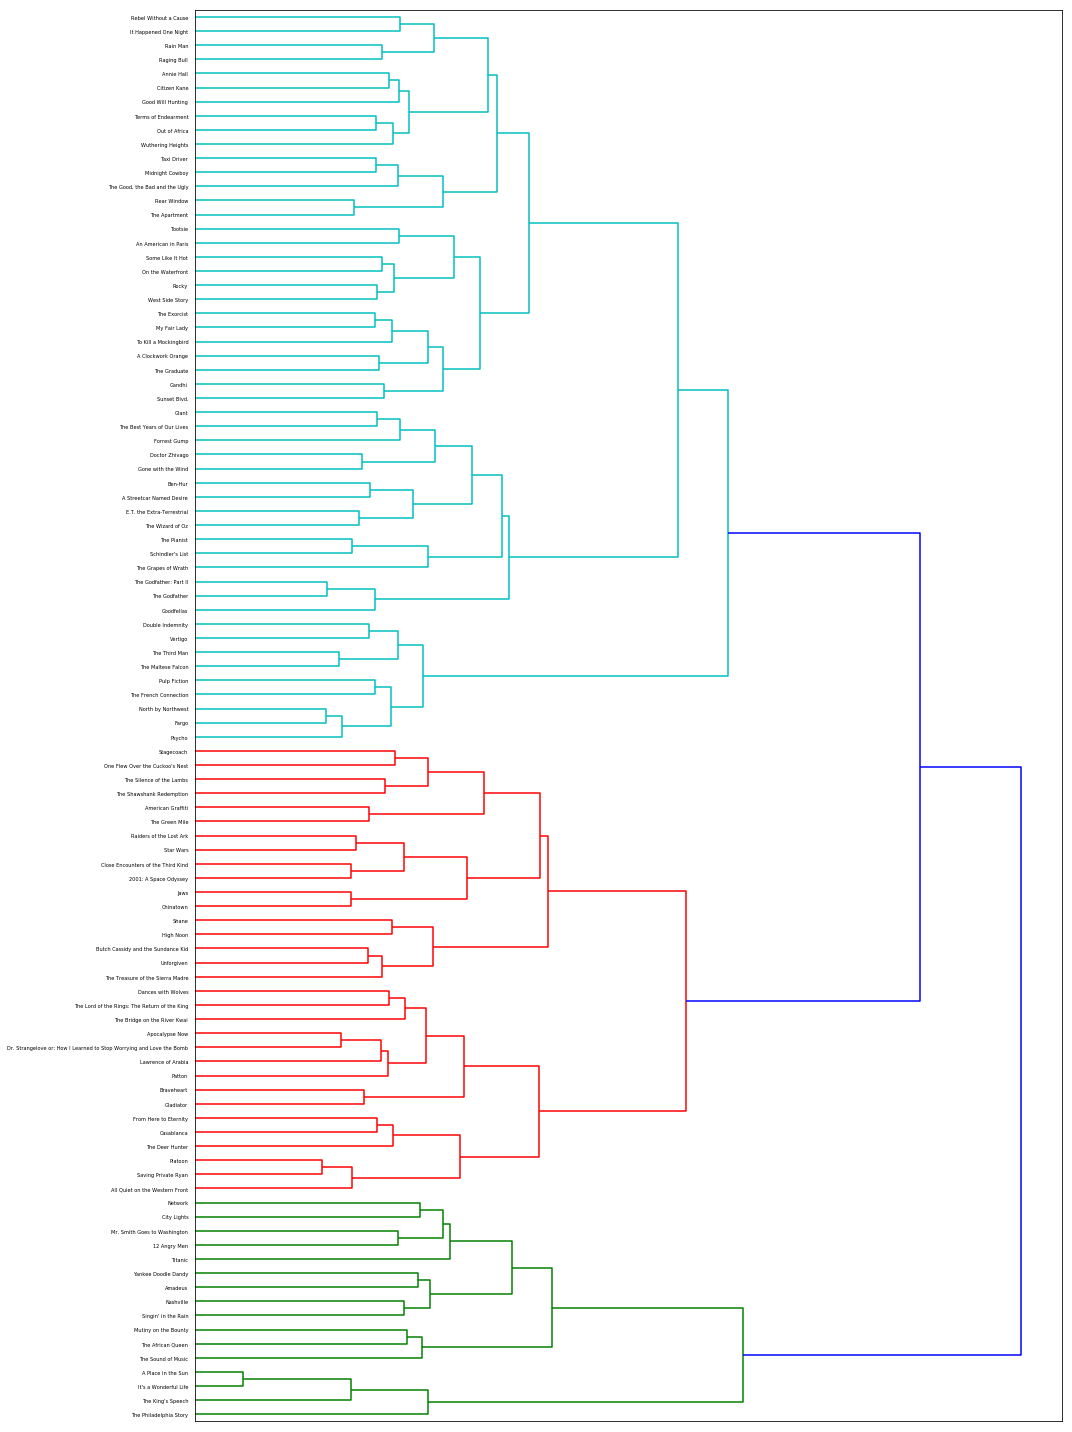

In [31]:
##层次聚类
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist) # 聚类算法处理之前计算得到的距离，用 linkage_matrix 表示
fig, ax = plt.subplots(figsize=(15, 20)) # 设置大小
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);
plt.tick_params(
        axis= 'x',          # 使用 x 坐标轴
        which='both',      # 同时使用主刻度标签（major ticks）和次刻度标签（minor ticks）
        bottom='off',      # 取消底部边缘（bottom edge）标签
        top='off',         # 取消顶部边缘（top edge）标签
    labelbottom='off')

plt.tight_layout() # 展示紧凑的绘图布局
# 注释语句用来保存图片
plt.savefig('ward_clusters.png', dpi=200) # 保存图片为 ward_clusters

In [ ]:
plt.close()                 